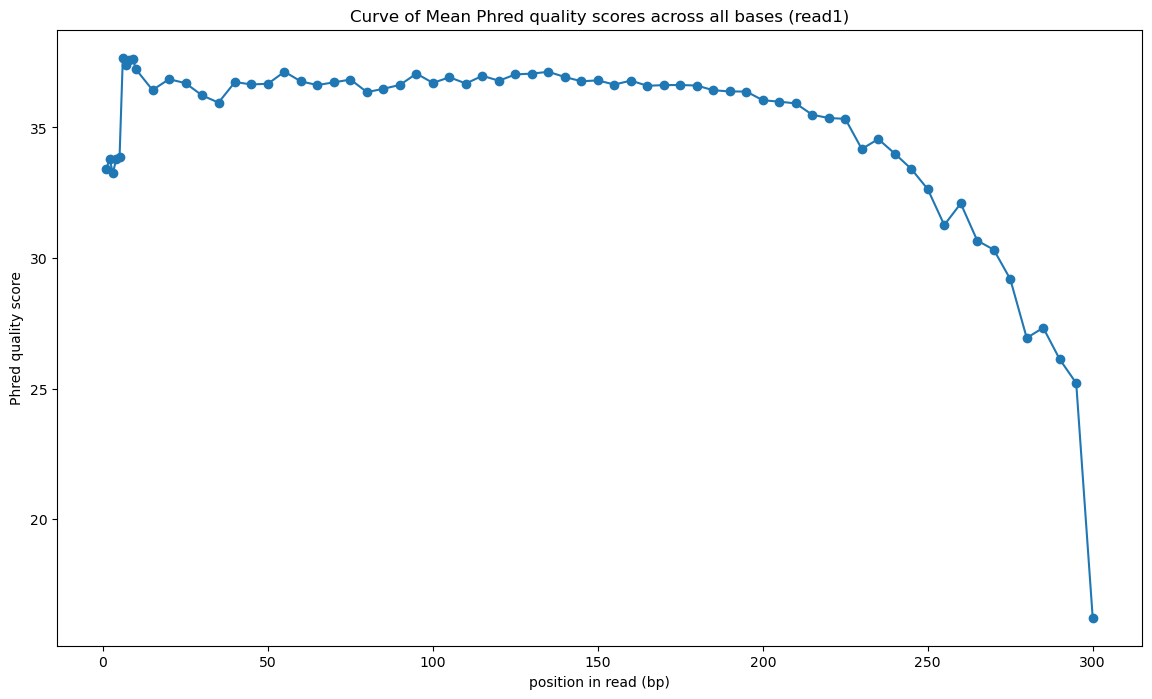

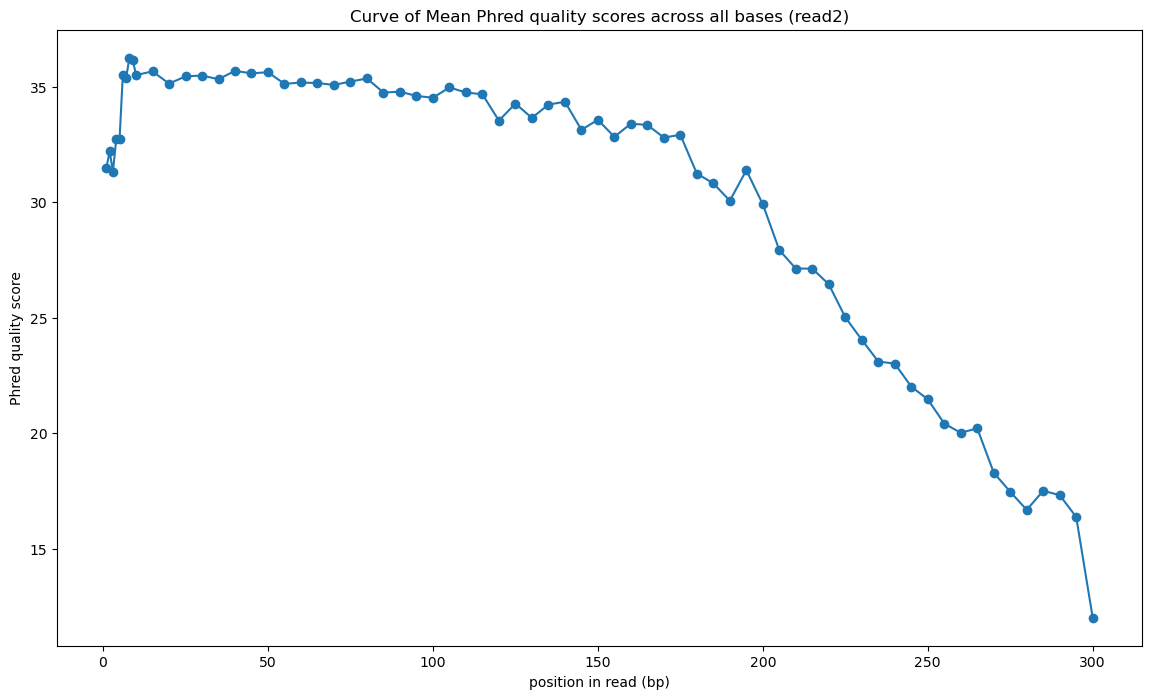

In [1]:
import matplotlib.pyplot as plt
import zipfile
import re

fastqc_file1 = '/Users/rjing/Desktop/read1_fastqc.zip'
fastqc_file2 = '/Users/rjing/Desktop/read2_fastqc.zip'

def parse_fastqc_data(fastqc_file):
    data = []
    with zipfile.ZipFile(fastqc_file, 'r') as zip_ref:
        for filename in zip_ref.namelist():
            if filename.endswith('.txt'):
                with zip_ref.open(filename) as file:
                    for line in file:
                        data.append(line.decode().strip().split())

    def find_indices(lst, target):
        return [index for index, element in enumerate(lst) if element == target]

    END_MODULE_indices = find_indices(data, ['>>END_MODULE'])

    start, end = 0, 0
    for i in data:
        if i == ['#Base', 'Mean', 'Median', 'Lower', 'Quartile', 'Upper', 'Quartile', '10th', 'Percentile', '90th', 'Percentile']:
            start = data.index(i)

    if start != -1 and end != -1:
        phred_scores = data[start:END_MODULE_indices[1]]

    for i in range(len(phred_scores)):
        phred_scores[i] = phred_scores[i][0:2]

    return phred_scores


def plot_phred_score_curve(phred_scores, fastqc_file):
    # Extract x and y data
    x = [int(item[0]) if '-' not in item[0] else int(item[0].split('-')[0]) for item in phred_scores[1:]]
    y = [float(item[1]) for item in phred_scores[1:]]
    read = fastqc_file.split('/')[-1].split('.')[0].split('_')[0]

    # Set figure size
    fig, ax = plt.subplots(figsize=(14, 8))

    # Plot the curve
    plt.plot(x, y, marker='o')
    plt.xlabel('position in read (bp)')
    plt.ylabel('Phred quality score')
    plt.title(f'Curve of Mean Phred quality scores across all bases ({read})')
    plt.show()

plot_phred_score_curve(parse_fastqc_data(fastqc_file1), fastqc_file1)
plot_phred_score_curve(parse_fastqc_data(fastqc_file2), fastqc_file2)


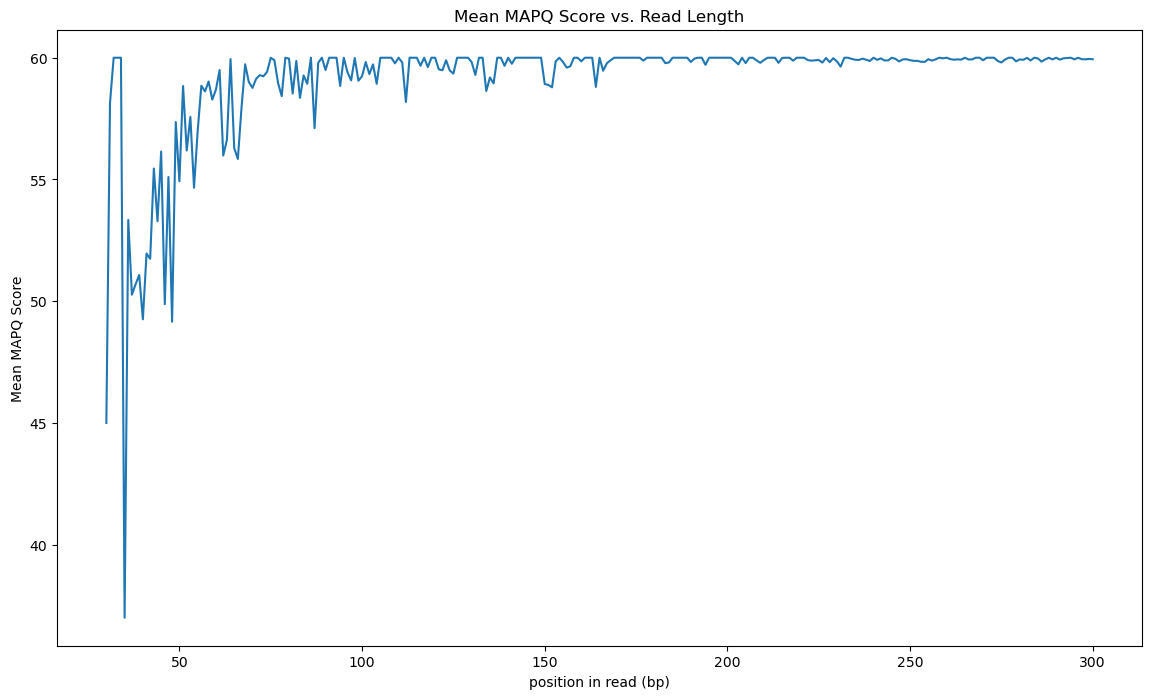

In [2]:
import pysam
import matplotlib.pyplot as plt

# SAM file path
sam_file = "/Users/rjing/Desktop/trim_read1_read2_alig.sam"


def parse_sam_data(sam_file):
    # Dictionary to store read lengths and total MAPQ scores
    read_lengths = {}
    total_mapq_scores = {}

    # Parse the SAM file and calculate total MAPQ scores for each read length
    with pysam.AlignmentFile(sam_file, "r") as sam:
        for read in sam.fetch():
            read_length = read.query_length
            mapq_score = read.mapping_quality

            if read_length in read_lengths:
                total_mapq_scores[read_length] += mapq_score
                read_lengths[read_length] += 1
            else:
                total_mapq_scores[read_length] = mapq_score
                read_lengths[read_length] = 1

    # Calculate mean MAPQ scores for each read length
    mean_mapq_scores = {
        read_length: total_score / read_lengths[read_length]
        for read_length, total_score in total_mapq_scores.items()
    }

    # Sort the read lengths in ascending order
    sorted_lengths = sorted(mean_mapq_scores.keys())
    return sorted_lengths, mean_mapq_scores

def plot_mapq_score_curve(sorted_lengths, mean_mapq_scores):
    # Create lists for x and y values
    x = sorted_lengths
    y = [mean_mapq_scores[read_length] for read_length in sorted_lengths]

    # Set figure size
    fig, ax = plt.subplots(figsize=(14, 8))

    # Plot the mean MAPQ score versus read length
    plt.plot(x, y)
    plt.xlabel("position in read (bp)")
    plt.ylabel("Mean MAPQ Score")
    plt.title("Mean MAPQ Score vs. Read Length")
    plt.show()

# Parse SAM data
sorted_lengths, mean_mapq_scores = parse_sam_data(sam_file)

# Plot the MAPQ score curve
plot_mapq_score_curve(sorted_lengths, mean_mapq_scores)


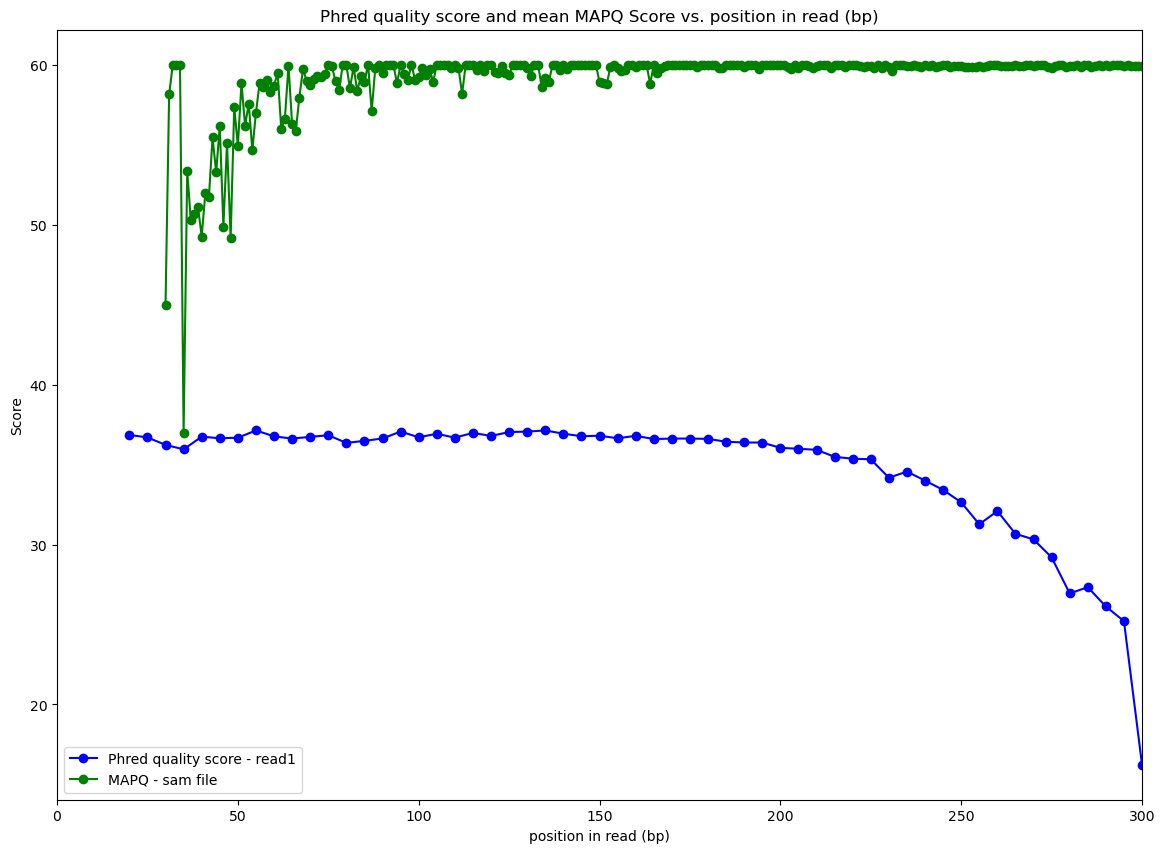

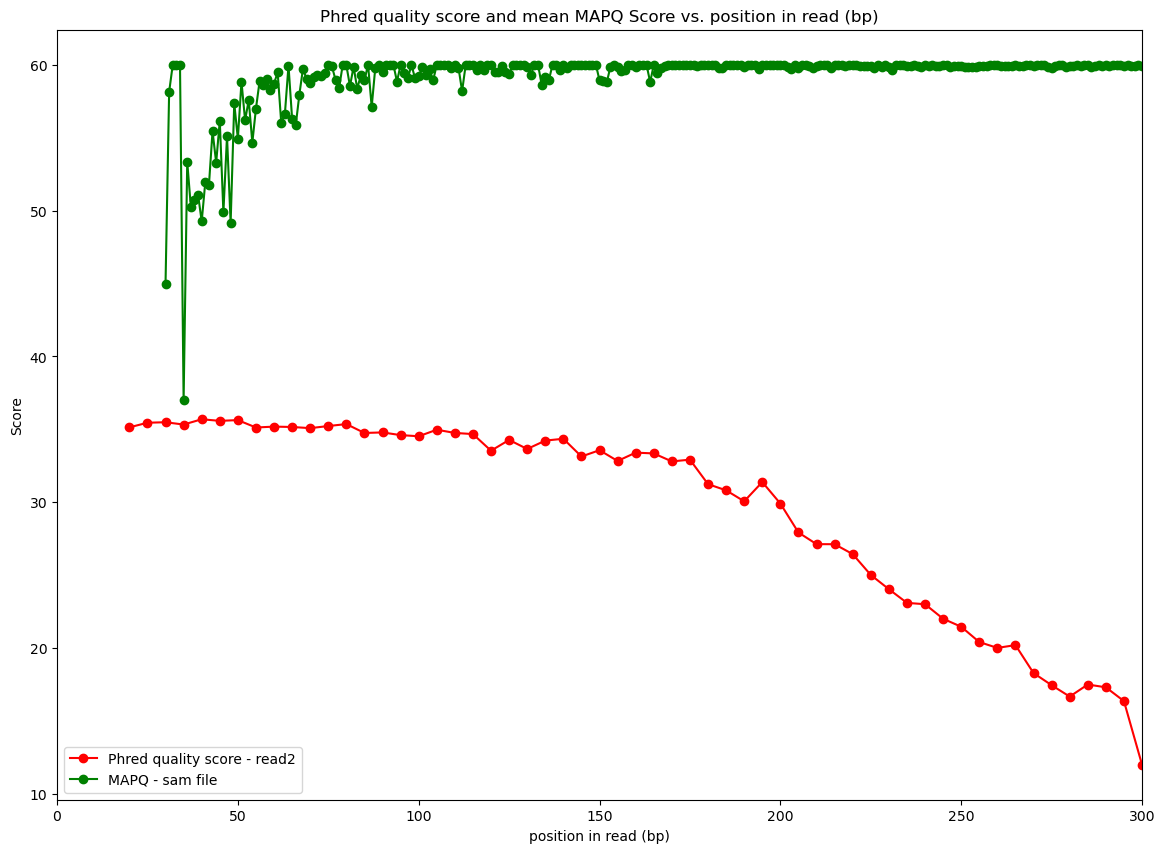

In [3]:
import matplotlib.pyplot as plt
import zipfile
import re
import pysam

fastqc_file1 = '/Users/rjing/Desktop/read1_fastqc.zip'
fastqc_file2 = '/Users/rjing/Desktop/read2_fastqc.zip'
sam_file = "/Users/rjing/Desktop/trim_read1_read2_alig.sam"

def parse_fastqc_data(fastqc_file):
    data = []
    with zipfile.ZipFile(fastqc_file, 'r') as zip_ref:
        for filename in zip_ref.namelist():
            if filename.endswith('.txt'):
                with zip_ref.open(filename) as file:
                    for line in file:
                        data.append(line.decode().strip().split())

    def find_indices(lst, target):
        return [index for index, element in enumerate(lst) if element == target]

    END_MODULE_indices = find_indices(data, ['>>END_MODULE'])

    start, end = 0, 0
    for i in data:
        if i == ['#Base', 'Mean', 'Median', 'Lower', 'Quartile', 'Upper', 'Quartile', '10th', 'Percentile', '90th', 'Percentile']:
            start = data.index(i)

    if start != -1 and end != -1:
        phred_scores = data[start:END_MODULE_indices[1]]

    for i in range(len(phred_scores)):
        phred_scores[i] = phred_scores[i][0:2]

    return phred_scores


def plot_phred_score_curve(phred_scores, fastqc_file, color):
    # Extract x and y data
    x = [int(item[0]) if '-' not in item[0] else int(item[0].split('-')[0]) for item in phred_scores[12:]]
    y = [float(item[1]) for item in phred_scores[12:]]
    read = fastqc_file.split('/')[-1].split('.')[0].split('_')[0]

    # Plot the curve
    plt.plot(x, y, marker='o', label=f"Phred quality score - {read}", color=color)


def parse_sam_data(sam_file):
    # Dictionary to store read lengths and total MAPQ scores
    read_lengths = {}
    total_mapq_scores = {}

    # Parse the SAM file and calculate total MAPQ scores for each read length
    with pysam.AlignmentFile(sam_file, "r") as sam:
        for read in sam.fetch():
            read_length = read.query_length
            mapq_score = read.mapping_quality

            if read_length in read_lengths:
                total_mapq_scores[read_length] += mapq_score
                read_lengths[read_length] += 1
            else:
                total_mapq_scores[read_length] = mapq_score
                read_lengths[read_length] = 1

    # Calculate mean MAPQ scores for each read length
    mean_mapq_scores = {
        read_length: total_score / read_lengths[read_length]
        for read_length, total_score in total_mapq_scores.items()
    }

    # Sort the read lengths in ascending order
    sorted_lengths = sorted(mean_mapq_scores.keys())
    return sorted_lengths, mean_mapq_scores


def plot_mapq_score_curve(sorted_lengths, mean_mapq_scores):
    # Create lists for x and y values
    x = sorted_lengths
    y = [mean_mapq_scores[read_length] for read_length in sorted_lengths]

    # Plot the mean MAPQ score versus read length
    plt.plot(x, y, marker='o', label="MAPQ - sam file", color='green')


def plotfig(fastqc_file, sam_file, color):
    # Set figure size
    fig, ax = plt.subplots(figsize=(14, 10))

    # Plot Phred score curve
    phred_scores = parse_fastqc_data(fastqc_file)
    plot_phred_score_curve(phred_scores, fastqc_file, color)

    # Plot MAPQ score curve
    sorted_lengths, mean_mapq_scores = parse_sam_data(sam_file)
    plot_mapq_score_curve(sorted_lengths, mean_mapq_scores)

    # Set x-axis limit based on Phred score curve
    x_limit = max([int(item[0]) if '-' not in item[0] else int(item[0].split('-')[0]) for item in phred_scores[12:]])
    plt.xlim(0, x_limit)

    # Set x-axis label
    plt.xlabel("position in read (bp)")

    # Set y-axis label
    plt.ylabel("Score")

    # Set plot title
    plt.title("Phred quality score and mean MAPQ Score vs. position in read (bp)")

    # Display legend
    plt.legend()

    # Show the plot
    plt.show()


plotfig(fastqc_file1, sam_file, 'blue')
plotfig(fastqc_file2, sam_file, 'red')
